In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from gns_utils import prepare_expr_files, csv_log_to_dataframe, split_dataframe, create_experiment_bash_with

EXPR_DIR = Path("gns_experiments")
CKPT_DIR = Path("checkpoints")
all_models = sorted(os.listdir(CKPT_DIR))
all_models

['0010000.pt', '0020000.pt', '0700000.pt', '0750000.pt']

In [3]:
path = EXPR_DIR / "1_true_grad_accuracy/results/"
files = [path / file for file in os.listdir(path)]
df = pd.concat([csv_log_to_dataframe(file, split=True) for file in files])

/Users/egecimsir/Desktop/GenAI Practical/Critical-Multitask-Batch-Sizes-in-Diffusion-Models/gns_utils.py:164: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["runtime"] = pd.to_datetime(df["runtime"])
/Users/egecimsir/Desktop/GenAI Practical/Critical-Multitask-Batch-Sizes-in-Diffusion-Models/gns_utils.py:164: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["runtime"] = pd.to_datetime(df["runtime"])
/Users/egecimsir/Desktop/GenAI Practical/Critical-Multitask-Batch-Sizes-in-Diffusion-Models/gns_utils.py:164: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["runtime"] = pd.t

In [4]:
meta, param, res = split_dataframe(df)
param

,model,t_min,t_max,diff_steps,true_portion
0,0010000.pt,NaN,NaN,1000,0.5
1,0010000.pt,NaN,NaN,1000,0.5
2,0010000.pt,NaN,NaN,1000,0.5
0,0010000.pt,NaN,NaN,1000,0.1
1,0010000.pt,NaN,NaN,1000,0.1
2,0010000.pt,NaN,NaN,1000,0.1
0,0010000.pt,NaN,NaN,1000,0.2
1,0010000.pt,NaN,NaN,1000,0.2


In [5]:
res

,gns_est,g_norm,b_true,t_min,t_max,runtime
0,3.262382,1.036614,25000,NaN,NaN,00:08:54.943879
1,3.137675,1.036454,25000,NaN,NaN,00:08:47.624477
2,6.946759,1.038726,25000,NaN,NaN,00:10:04.787752
0,2.051962,1.030378,5000,NaN,NaN,00:04:24.266915
1,0.825525,1.026069,5000,NaN,NaN,00:04:24.933039
2,0.746371,1.023740,5000,NaN,NaN,00:04:31.742532
0,2.481508,1.030459,10000,NaN,NaN,00:05:36.398353
1,2.298279,1.034712,10000,NaN,NaN,00:06:25.197141


In [6]:
df = pd.concat([param, res], axis=1).drop(["t_min", "t_max", "diff_steps"], axis=1)
df

,model,true_portion,gns_est,g_norm,b_true,runtime
0,0010000.pt,0.5,3.262382,1.036614,25000,00:08:54.943879
1,0010000.pt,0.5,3.137675,1.036454,25000,00:08:47.624477
2,0010000.pt,0.5,6.946759,1.038726,25000,00:10:04.787752
0,0010000.pt,0.1,2.051962,1.030378,5000,00:04:24.266915
1,0010000.pt,0.1,0.825525,1.026069,5000,00:04:24.933039
2,0010000.pt,0.1,0.746371,1.023740,5000,00:04:31.742532
0,0010000.pt,0.2,2.481508,1.030459,10000,00:05:36.398353
1,0010000.pt,0.2,2.298279,1.034712,10000,00:06:25.197141


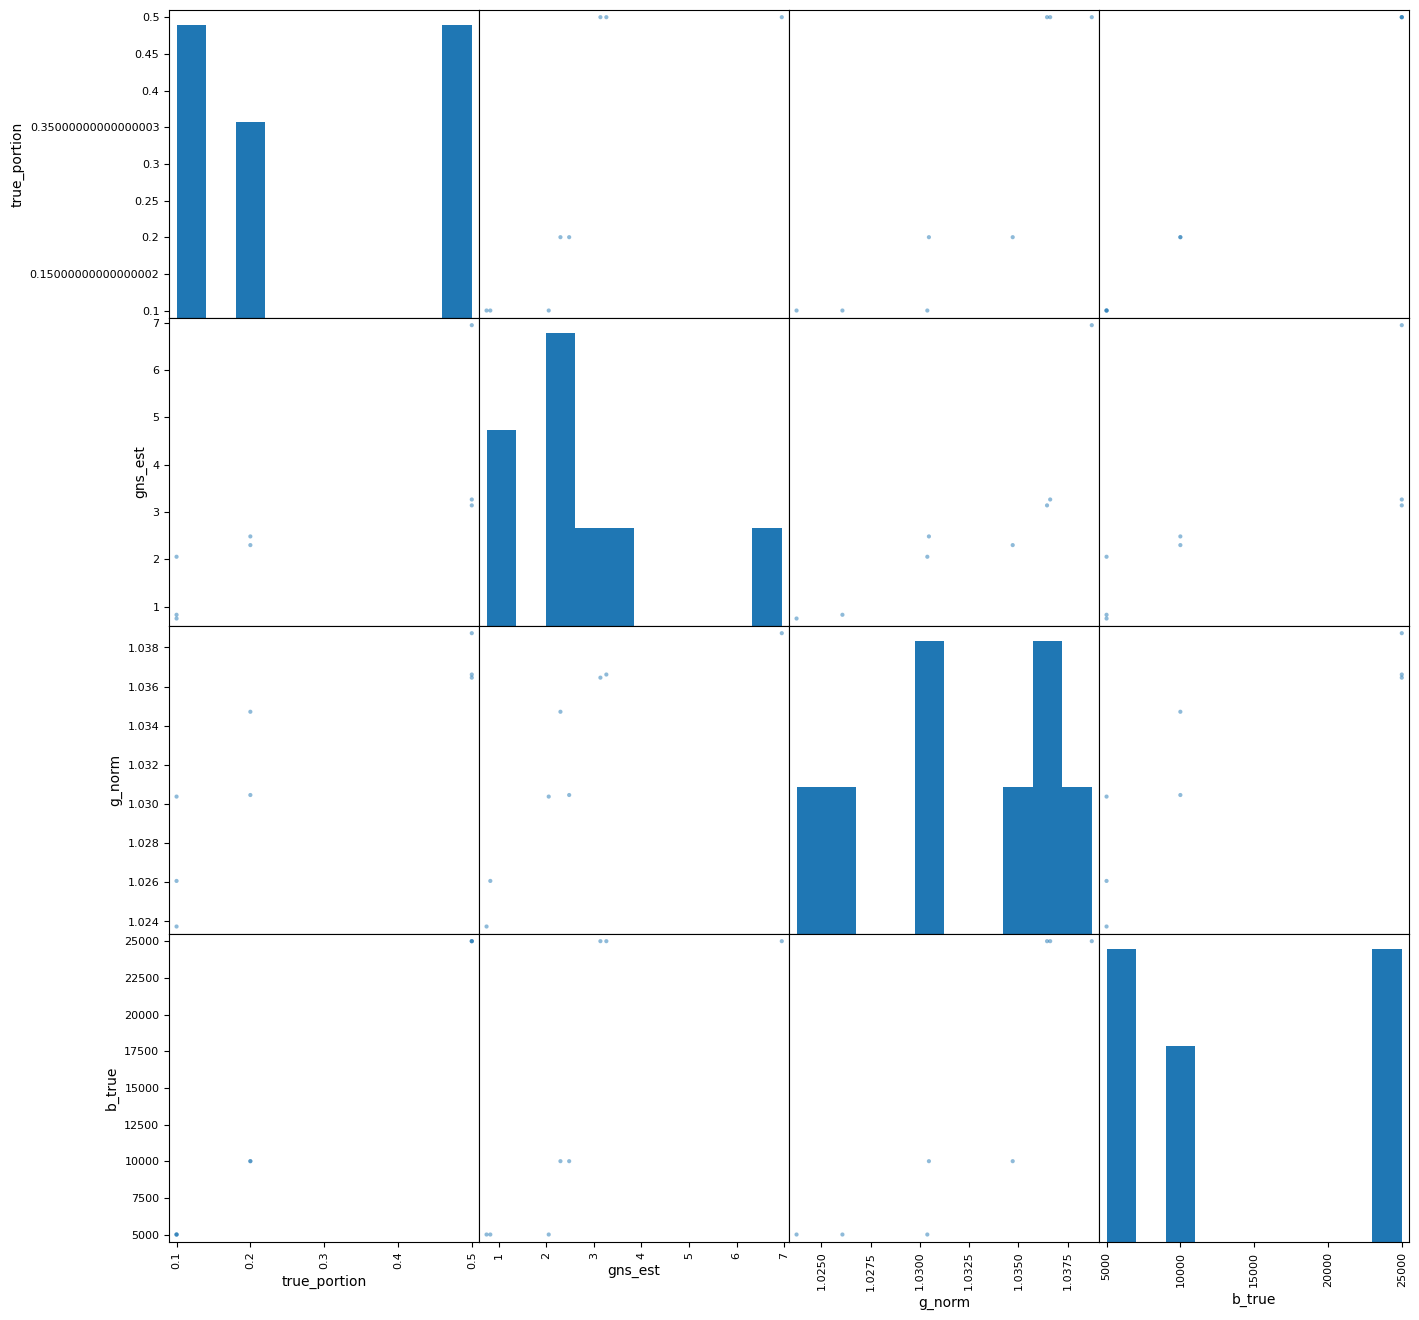

In [7]:
pd.plotting.scatter_matrix(df, figsize=(16, 16))
plt.show()